Notebook for exploration of various ML methods of granule segmentation

In [12]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
import funclib
tc = 'black'

### UNSUPERVISED

Canned Sci-Kit algorithms (see https://scikit-learn.org/stable/modules/clustering.html)

Pick algorithms that are scalable to large n
     
Features

        Pixel value 
        Gradient values
        Other features, for example derived from sklearn.feature_extraction (not yet attempted)

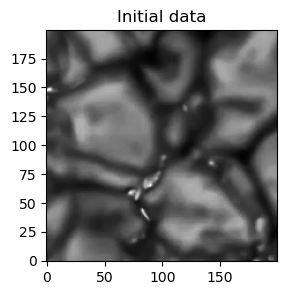

<Figure size 640x480 with 0 Axes>

In [14]:
# Get data
path = "Data/DKIST_example.fits"
data = fits.open(path)[0].data
labels = np.squeeze(fits.open("Data/DKIST_solarseg_output.fits")[0].data) # just to check against

# Cut data to smaller size and flatten
data = data[100:300, 100:300]
labels = labels[100:300, 100:300]
dataflat = data.reshape(-1)

# Plot data for comparison
plt.figure(figsize=(3, 3))
plt.imshow(data, cmap='gray', origin='lower')
plt.title('Initial data', color=tc)
plt.tick_params(labelcolor=tc, color=tc)
plt.figure()

# Create features and put into df (skip kernel feature for now - contain inf and probably not super useful anyway)
df = pd.DataFrame()
df['OG_value'] = dataflat
df = funclib.add_gradient_feats(df, data) # Add value of gradient as feature
df = funclib.add_sharpening_feats(df, dataflat) # Add value of sharpening filters as features RIGHT NOW JUST SQUARED

KMeans clustering
    n_clusters=2, init=k-means++, "accuracy": 0.884975
    n_clusters=2, init=random, "accuracy": 0.884975


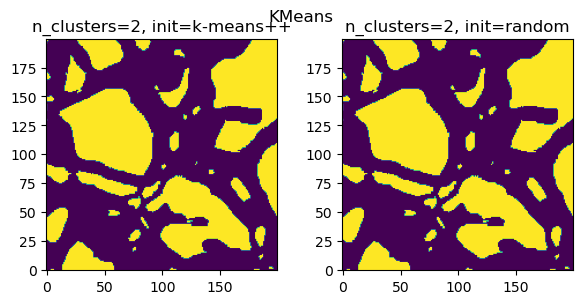

In [9]:
'''
Just 2-value segmentation 
'''

# 1) KMeans ############################################################################
#
#       Clusters by separating into n groups of equal variance, minimizing within-cluster sum-of-squares
#       Overall, this seems to overestimate IGM
#       3 clusters does not ID brightpoints (even with addition of gradient features) - but potentially is useful for IDing dim outskirts and centers

from sklearn.cluster import KMeans

print('KMeans clustering')
n_clusterss = [2]
inits = ['k-means++', 'random'] # can also try passing locs of centers if use another alg to determine

dict = {}
i = 0
for n_clusters in n_clusterss:
    for init in inits:
        preds_flat = KMeans(n_clusters=n_clusters, init=init, n_init=10).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        preds = funclib.post_process(preds) # make sure IG is addigned to 0, G to 1
        dict[str(i)] = [n_clusters, init, preds]
        i += 1
        pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
        print('    n_clusters='+str(n_clusters)+', init='+str(init)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('KMeans', color=tc)
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    init = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', init='+str(init), color=tc)
for ax in axs: ax.tick_params(labelcolor=tc, color=tc)


# # 2) AgglomorativeCluster ################################################################
# #
# #       Build clusters by finding closest pairs, merging iteratively 
# #       Does best with 3 clusters, 'complete' linkage, 'euclidean' metric:
# #           Without gradient feature, 3rd cluster becomes rings around granules, not brightpoints
# #           With gradient feature, maybe finds dim middles?

# from sklearn.cluster import AgglomerativeClustering

# print('AgglomerativeClustering')
# n_clusterss = [2] 
# metrics = ['euclidean'] #  'l1', 'manhattan' seem to do similarly (at least with n_clusters=2) 
# linkages = ['complete', 'ward'] # 'average' and 'single' do terrible

# dict = {}
# i = 0
# for n_clusters in n_clusterss:
#     for metric in metrics:
#         for linkage in linkages:
#             preds_flat = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage).fit(df.values).labels_
#             preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
#             preds = funclib.post_process(preds) # make sure IG is addigned to 0, G to 1
#             dict[str(i)] = [n_clusters, metric, linkage, preds]
#             i += 1
#             pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
#             print('    n_clusters='+str(n_clusters)+', linkage='+str(linkage)+ ', "accuracy":', pct_correct)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
# fig.suptitle('AgglomorativeClustering', color=tc)
# axs = [ax1, ax2]
# for i in range(len(axs)):
#     n_clusters =  dict[str(i)][0]
#     metric = dict[str(i)][1]
#     linkage = dict[str(i)][2]
#     preds = dict[str(i)][3]
#     axs[i].imshow(preds, origin='lower')
#     axs[i].set_title('n_clusters='+str(n_clusters)+', linkage='+str(linkage), color=tc)
# for ax in axs: ax.tick_params(labelcolor=tc, color=tc)


KMeans clustering


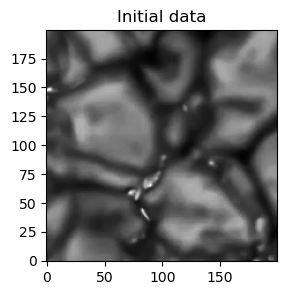

<Figure size 640x480 with 0 Axes>

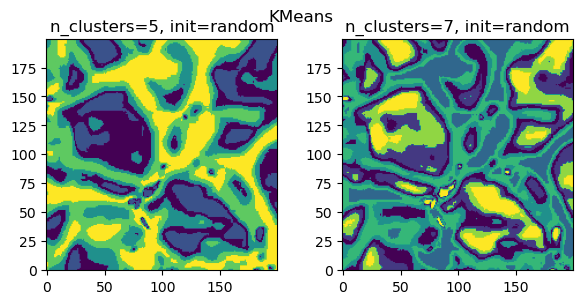

In [17]:
'''
> 2 value segmentation
'''

# Cut data to smaller size and flatten
data = data[100:300, 100:300]
labels = labels[100:300, 100:300]
dataflat = data.reshape(-1)

# Plot data for comparison
plt.figure(figsize=(3, 3))
plt.imshow(data, cmap='gray', origin='lower')
plt.title('Initial data', color=tc)
plt.tick_params(labelcolor=tc, color=tc)
plt.figure()

# 1) KMeans ############################################################################
#
#   What if we use large n_clusters, but then combine some?
#   Looks like this could work!
#   But since the actual numeric labels assigned are arbitrary (and thus change between runs), how can I group them?
#   Need some way to automatically detect the numeric labels that should be grouped into each class! 

from sklearn.cluster import KMeans

print('KMeans clustering')
n_clusterss = [5, 7]
inits = ['random']

dict = {}
i = 0
for n_clusters in n_clusterss:
    for init in inits:
        preds_flat = KMeans(n_clusters=n_clusters, init=init, n_init=10).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        #preds = funclib.post_process(preds) # make sure IG is assigned to 0, G to 1
        dict[str(i)] = [n_clusters, init, preds]
        i += 1
        #pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
        #print('    n_clusters='+str(n_clusters)+', init='+str(init)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('KMeans', color=tc)
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    init = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', init='+str(init), color=tc)
for ax in axs: ax.tick_params(labelcolor=tc, color=tc)

# # 2) AgglomorativeCluster ################################################################
# #
# #       Build nested clusters by merging and splitting them successively
# #       Does best with 3 clusters, 'complete' linkage, 'euclidean' metric:
# #           Without gradient feature, 3rd cluster becomes rings around granules, not brightpoints
# #           With gradient feature, maybe finds dim middles?

# from sklearn.cluster import AgglomerativeClustering

# n_clusterss = [3] #[2, 3]
# metrics = ['euclidean'] #  'l1', 'manhattan' seem to do similarly (at least with n_clusters=2) 
# linkages = ['complete', 'ward', 'single', 'average'] # 'average' and 'single' do terrible

# dict = {}
# i = 0
# for n_clusters in n_clusterss:
#     for metric in metrics:
#         for linkage in linkages:
#             preds_flat = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage=linkage).fit(df.values).labels_
#             preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
#             dict[str(i)] = [n_clusters, metric, linkage, preds]
#             i += 1

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7)) # fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
# fig.suptitle('AgglomerativeClustering', color=tc)
# axs = [ax1, ax2, ax3, ax4] # [ax1, ax2, ax3, ax4, ax5, ax6]
# for i in range(len(axs)):
#     n_clusters =  dict[str(i)][0]
#     metric = dict[str(i)][1]
#     linkage = dict[str(i)][2]
#     preds = dict[str(i)][3]
#     axs[i].imshow(preds, origin='lower')
#     axs[i].set_title('n_clusts='+str(n_clusters)+', metric='+str(metric)+', linkage='+str(linkage), color=tc)

# for ax in axs:
#     ax.tick_params(labelcolor=tc, color=tc)



# # 3) DBSCAN ############################################################################
# #
# #       Unsupervised algorithm
# #       Clusters by identifying areas of high density separated by areas of low density 
# #       MUCH faster than OPTICS, but same very poor results -  tons of tiny little pixel groups

# from sklearn.cluster import DBSCAN

# epss = [10, 30] # must be larger for more features (0.5 works fine for 1 feature)
# min_sampless = [50, 100, 200]
# metric = 'euclidean'
# algorithm = 'auto'

# dict = {}
# i = 0
# for eps in epss:
#     for min_samples in min_sampless:
#         preds_flat = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, n_jobs=3).fit(df.values).labels_
#         preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
#         dict[str(i)] = [eps, min_samples, preds]
#         i += 1

# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
# fig.suptitle('DBSCAN', color='white')
# axs = [ax1, ax2, ax3, ax4, ax5, ax6]
# for i in range(len(axs)):
#     eps =  dict[str(i)][0]
#     min_samples = dict[str(i)][1]
#     preds = dict[str(i)][2]
#     axs[i].imshow(preds, origin='lower')
#     axs[i].set_title('eps='+str(eps)+', min_samps='+str(min_samples), color=tc)

# for ax in axs:
#     ax.tick_params(labelcolor=tc, color=tc)


# # 3) OPTICS ############################################################################
# #
# #       Unsupervised algorithm
# #       Works simlarly to DBSCAN
# #       Performs similarly to DBSCAN but takes longer

# from sklearn.cluster import OPTICS

# max_epss = [20] # must be larger for more features (0.5 works fine for 1 feature)
# min_sampless = [4, 10] # doesn't seem to have much effect 
# metric = 'euclidean'
# algorithm = 'auto'
# min_cluster_sizes = [20, 1000, 3000] # [50, 100, 200]
# dict = {}
# i = 0
# for eps in max_epss:
#     for min_samples in min_sampless:
#         for min_cluster_size in min_cluster_sizes:
#             preds_flat = OPTICS(max_eps=eps, min_samples=min_samples, min_cluster_size=min_cluster_size, metric=metric, algorithm=algorithm).fit(df.values).labels_
#             preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
#             dict[str(i)] = [eps, min_samples, min_cluster_size, preds]
#             i += 1

# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
# fig.suptitle('OPTICS', color=tc)
# axs = [ax1, ax2, ax3, ax4, ax5, ax6]
# for i in range(len(axs)):
#     max_eps =  dict[str(i)][0]
#     min_samples = dict[str(i)][1]
#     min_cluster_size = dict[str(i)][2]
#     preds = dict[str(i)][3]
#     axs[i].imshow(preds, origin='lower')
#     axs[i].set_title('max_eps='+str(max_eps)+', min_samp='+str(min_cluster_size)+', min_clustsize='+str(min_cluster_size), color='white')

# for ax in axs:
#     ax.tick_params(labelcolor=tc, color=tc)

### SUPERVISED

Note 1: currently using mostly default tunning parameters - could do more exploration to pick best ones

Note 2: currently using validation set from same image as training and test sets.
        Ideally could use new DKIST (DKIST_gband_series) for validation. 

Note 3: Why are validation accuracies higher than test accuracies? And why are test accuracies so high?
        Have I screwed something up?
        
        - Probably is just legit learning the thresholding perfectly, its a very simple metric
        - If thats the case, should get ~100% if test against segmented without BPs and DMs (when trained 
          on no BPs and DMs) and very close when trained on full. 

RF Trained on OG
     accuracy on OG test set:  0.9852530518380191
     accuracy on OG validation set:  0.988648194503391
     accuracy on 50_36 validation set:  0.20092957103946116
     accuracy on combined test set:  0.6062977660199882
RF trained on 51_58
     accuracy on OG validation set:  0.49401834512745446
     accuracy on 50_36 validation set:  0.9897983335345972
     accuracy on combined test set:  0.7168274717294325
RF trained on combined
     accuracy on OG validation set:  0.9880990532944142
     accuracy on 50_36 validation set:  0.9685513021776758
     accuracy on combined test set:  0.9877191617387696
KNN Trained on OG
     accuracy on OG test set:  0.9853135698723934
     accuracy on OG validation set:  0.9888534728417625
     accuracy on 50_36 validation set:  0.26445276335386225
     accuracy on combined test set:  0.626002870283916
KNN trained on 51_58
     accuracy on OG validation set:  0.49401834512745446
     accuracy on 50_36 validation set:  0.9672492586778301


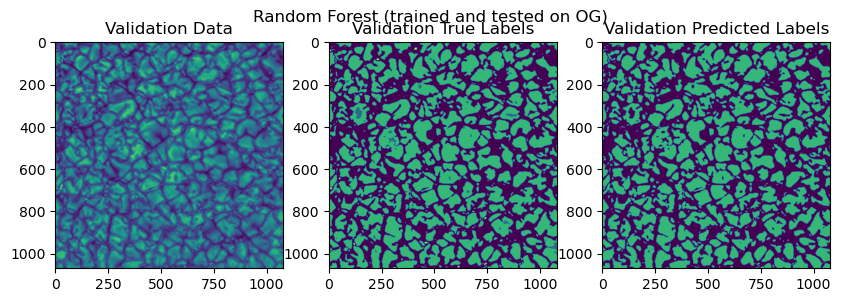

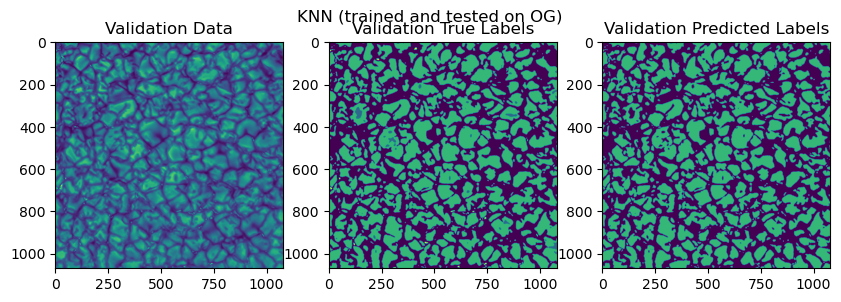

In [15]:
'''
Try out various combinations of training and testing sets
'''

# Get data (DKIST image) and labels (using our non-ML id method)
data_OG = fits.open("Data/DKIST_example.fits")[0].data.byteswap().newbyteorder() # Not sure why this is big-endian to start with..
labels_OG = np.squeeze(fits.open("Data/DKIST_solarseg_output.fits")[0].data) # "c:\\Users\\lea\\OneDrive\\DKISTSegmentation\\DKISTSegmentation\\example_outputs\\DKIST\\segmented_data_DKIST_example.fits"
labels_noBPDMs = np.squeeze(fits.open("Data/DKIST_solarseg_output_noBPDMs.fits" )[0].data) # all files I created with run_segment_algorithm have first hdu shape (1,x,x)
data_50_36 = fits.open('Data/DKIST_gband_series_183653/SEG_VBI_2022_06_03T18_50_36_353_00430500_I_BPDWB_L1.fits')[1].data.byteswap().newbyteorder() # Not sure why this is big-endian to start with..
labels_50_36 = np.squeeze(fits.open('Data/DKIST_gband_series_183653/SEG_VBI_2022_06_03T18_50_36_353_00430500_I_BPDWB_L1.fits')[0].data)
data_51_58 = fits.open('Data/DKIST_gband_series_183653/SEG_VBI_2022_06_03T18_51_58_613_00430500_I_BPDWB_L1.fits')[1].data.byteswap().newbyteorder() # Not sure why this is big-endian to start with..
labels_51_58 = np.squeeze(fits.open('Data/DKIST_gband_series_183653/SEG_VBI_2022_06_03T18_51_58_613_00430500_I_BPDWB_L1.fits')[0].data)

# Prepare half (really 1/4) data for training and testing (use second half for first validation)
tt_data_OG = data_OG[0:int(np.shape(data_OG)[0]/2), 0:int(np.shape(data_OG)[1]/2)]
tt_labels_OG = labels_OG[0:int(np.shape(labels_OG)[0]/2), 0:int(np.shape(labels_OG)[1]/2)]
X_tt_OG, Y_tt_OG = funclib.pre_proccess(tt_data_OG, tt_labels_OG)
X_train_OG, X_test_OG, Y_train_OG, Y_test_OG = train_test_split(X_tt_OG, Y_tt_OG, test_size=0.4, random_state=20)

# Create validation set Y and Y using same steps as above
val_data_OG = data_OG[int(np.shape(data_OG)[0]/2):-1, int(np.shape(data_OG)[1]/2):-1]
val_labels_OG = labels_OG[int(np.shape(labels_OG)[0]/2):-1, int(np.shape(labels_OG)[1]/2):-1] #labels[int(np.shape(labels)[0]/2):-1, int(np.shape(labels)[1]/2):-1]
X_val_OG, Y_val_OG = funclib.pre_proccess(val_data_OG, val_labels_OG)

# Create "secondary" train and test sets (with a new data file)
X_tt_51_58, Y_tt_51_58 = funclib.pre_proccess(data_51_58, labels_51_58)
X_train_51_58, X_test_51_58, Y_train_51_58, Y_test_51_58 = train_test_split(X_tt_51_58, Y_tt_51_58, test_size=0.4, random_state=20)

# Create "secondary" validation set (a different new data file)
X_val_50_36, Y_val_50_36 = funclib.pre_proccess(data_50_36, labels_50_36)

# Create combined training set - WILL THE BOUNDARY CREATE PROBLEMS??? BUT I GUESS TRAIN_TEST_SPLIT (WHICH HONESTLY I SHOULDNT DO) WILL REMOVE THAT ISSUE
dataset1 = data_OG[0:int(np.shape(data_OG)[0]/2), 0:int(np.shape(data_OG)[1]/4)]
dataset2 = data_51_58[100:np.shape(dataset1)[0]+100, 100:np.shape(dataset1)[1]+100] # shift by 100 to aviod constant boundary
data_comb = np.concatenate((dataset1, dataset2), axis=1)
labelset1 = labels_OG[0:int(np.shape(labels_OG)[0]/2), 0:int(np.shape(labels_OG)[1]/4)]
labelset2 = labels_51_58[100:np.shape(labelset1)[0]+100, 100:np.shape(labelset1)[1]+100] # shift by 100 to aviod constant boundary
labels_comb = np.concatenate((labelset1, labelset2), axis=1)
X_tt_comb, Y_tt_comb = funclib.pre_proccess(data_comb, labels_comb)
X_train_comb, X_test_comb, Y_train_comb, Y_test_comb = train_test_split(X_tt_comb, Y_tt_comb, test_size=0.4, random_state=20)

# 1) RandomForestClassifier ###############################################################

# Train on OG train set
print('RF Trained on OG')
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train_OG, Y_train_OG)

# Predict on OG test set
pred_test_OG =  model.predict(X_test_OG)
print('     accuracy on OG test set: ', metrics.accuracy_score(Y_test_OG, pred_test_OG))

# Predict on OG validation set
pred_val_OG =  model.predict(X_val_OG)
print('     accuracy on OG validation set: ', metrics.accuracy_score(Y_val_OG, pred_val_OG))

# Predict on validation set 2 
pred_val_50_36 =  model.predict(X_val_50_36)
print('     accuracy on 50_36 validation set: ', metrics.accuracy_score(Y_val_50_36, pred_val_50_36))

# Predict on combined test set
pred_test_comb =  model.predict(X_test_comb)
print('     accuracy on combined test set: ', metrics.accuracy_score(Y_test_comb, pred_test_comb))

# Train on 51_58 set 
print('RF trained on 51_58')
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train2, Y_train2)

# Predict on OG validation set
pred_val_OG =  model.predict(X_val_OG)
print('     accuracy on OG validation set: ', metrics.accuracy_score(Y_val_OG, pred_val_OG))

# Predict on validation set 2 
pred_val_50_36 =  model.predict(X_val_50_36)
print('     accuracy on 50_36 validation set: ', metrics.accuracy_score(Y_val_50_36, pred_val_50_36))

# Predict on combined test set
pred_test_comb =  model.predict(X_test_comb)
print('     accuracy on combined test set: ', metrics.accuracy_score(Y_test_comb, pred_test_comb))

# Train on combined set 
print('RF trained on combined')
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train_comb, Y_train_comb)

# Predict on OG validation set
pred_val_OG =  model.predict(X_val_OG)
print('     accuracy on OG validation set: ', metrics.accuracy_score(Y_val_OG, pred_val_OG))

# Predict on validation set 2 
pred_val_50_36 =  model.predict(X_val_50_36)
print('     accuracy on 50_36 validation set: ', metrics.accuracy_score(Y_val_50_36, pred_val_50_36))

# Predict on combined test set
pred_test_comb =  model.predict(X_test_comb)
print('     accuracy on combined test set: ', metrics.accuracy_score(Y_test_comb, pred_test_comb))

# Plot
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.suptitle('Random Forest (trained and tested on OG)', color=tc)
axs[0].imshow(val_data)
axs[0].set_title('Validation Data', color=tc)
axs[1].imshow(Y_val.reshape(np.shape(val_data)[0], np.shape(val_data)[1]))
axs[1].set_title('Validation True Labels', color=tc)
axs[2].imshow(pred_val.reshape(np.shape(val_data)[0], np.shape(val_data)[1]))
axs[2].set_title('Validation Predicted Labels', color=tc)
for ax in axs:
    ax.tick_params(labelcolor=tc, color=tc)

# 2) KNeighborsClassifier ###############################################################

# Train on OG train set
print('KNN Trained on OG')
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_OG, Y_train_OG)

# Predict on OG test set
pred_test_OG =  model.predict(X_test_OG)
print('     accuracy on OG test set: ', metrics.accuracy_score(Y_test_OG, pred_test_OG))

# Predict on OG validation set
pred_val_OG =  model.predict(X_val_OG)
print('     accuracy on OG validation set: ', metrics.accuracy_score(Y_val_OG, pred_val_OG))

# Predict on validation set 2 
pred_val_50_36 =  model.predict(X_val_50_36)
print('     accuracy on 50_36 validation set: ', metrics.accuracy_score(Y_val_50_36, pred_val_50_36))

# Predict on combined test set
pred_test_comb =  model.predict(X_test_comb)
print('     accuracy on combined test set: ', metrics.accuracy_score(Y_test_comb, pred_test_comb))

# Train on 51_58 set 
print('KNN trained on 51_58')
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_51_58, Y_train_51_58)

# Predict on OG validation set
pred_val_OG =  model.predict(X_val_OG)
print('     accuracy on OG validation set: ', metrics.accuracy_score(Y_val_OG, pred_val_OG))

# Predict on validation set 2 
pred_val_50_36 =  model.predict(X_val_50_36)
print('     accuracy on 50_36 validation set: ', metrics.accuracy_score(Y_val_50_36, pred_val_50_36))

# Predict on combined test set
pred_test_comb =  model.predict(X_test_comb)
print('     accuracy on combined test set: ', metrics.accuracy_score(Y_test_comb, pred_test_comb))

# Train on combined set 
print('KNN trained on combined')
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_comb, Y_train_comb)

# Predict on OG validation set
pred_val_OG =  model.predict(X_val_OG)
print('     accuracy on OG validation set: ', metrics.accuracy_score(Y_val_OG, pred_val_OG))

# Predict on validation set 2 
pred_val_50_36 =  model.predict(X_val_50_36)
print('     accuracy on 50_36 validation set: ', metrics.accuracy_score(Y_val_50_36, pred_val_50_36))

# Predict on combined test set
pred_test_comb =  model.predict(X_test_comb)
print('     accuracy on combined test set: ', metrics.accuracy_score(Y_test_comb, pred_test_comb))

# Plot
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.suptitle('KNN (trained and tested on OG)', color=tc)
axs[0].imshow(val_data)
axs[0].set_title('Validation Data', color=tc)
axs[1].imshow(Y_val.reshape(np.shape(val_data)[0], np.shape(val_data)[1]))
axs[1].set_title('Validation True Labels', color=tc)
axs[2].imshow(pred_val.reshape(np.shape(val_data)[0], np.shape(val_data)[1]))
axs[2].set_title('Validation Predicted Labels', color=tc)
for ax in axs:
    ax.tick_params(labelcolor=tc, color=tc)


In [15]:
'''
Same as above but simplify - create one big combined set to take train/test/val data from
'''

# Get data (DKIST image) and labels 
data = fits.open("Data/DKIST_example.fits")[0].data.byteswap().newbyteorder()[0:1365, 0:1365]
labels = np.squeeze(fits.open("Data/DKIST_solarseg_output.fits")[0].data)[0:1365, 0:1365]
for file in os.listdir('Data/DKIST_gband_series_183653/'):
        if file.startswith('SEG_'):
            path = 'Data/DKIST_gband_series_183653/'+file
            data1 = fits.open(path)[1].data.byteswap().newbyteorder()
            data = np.concatenate((data, data1), axis=1)
            labels1 = np.squeeze(fits.open(path)[0].data)
            labels = np.concatenate((labels, labels1), axis=1)

# Prepare half for training and testing (split along 'short' axis to encompass all)
tt_data = data[0:int(np.shape(data)[0]/2), :]
tt_labels = labels[0:int(np.shape(data)[0]/2), :]
X_tt, Y_tt = funclib.pre_proccess(tt_data, tt_labels)
X_train, X_test, Y_train, Y_test = train_test_split(X_tt, Y_tt, test_size=0.4, random_state=20)

# Prepare other half for validation
tt_data = data[int(np.shape(data)[0]/2):-1, :]
tt_labels = labels[int(np.shape(data)[0]/2):-1, :]
X_val, Y_val = funclib.pre_proccess(tt_data, tt_labels)


# 1) RandomForestClassifier ###############################################################

# Train on train set
print('RF')
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, Y_train)

# Predict on test set
pred_test =  model.predict(X_test)
print('     accuracy on test set: ', metrics.accuracy_score(Y_test, pred_test))

# Predict on OG validation set
pred_val =  model.predict(X_val)
print('     accuracy on validation set: ', metrics.accuracy_score(Y_val, pred_val))

# # 2) KNeighborsClassifier ###############################################################

# # Train on train set
# print('KNN')
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(X_train, Y_train)

# # Predict on test set
# pred_test =  model.predict(X_test)
# print('     accuracy on test set: ', metrics.accuracy_score(Y_test, pred_test))

# # Predict on OG validation set
# pred_val =  model.predict(X_val)
# print('     accuracy on validation set: ', metrics.accuracy_score(Y_val, pred_val))



RF
     accuracy on test set:  0.9587503893955507
     accuracy on validation set:  0.9522060734963961


In [ ]:
# # Add values of different Gabor filters as features
# num = 1
# kernels = []
# for theta in range(2):
#     theta = theta/4 * np.pi
#     for sigma in [1,3]:
#         for lambd in np.arange(0, np.pi, np.pi/4):
#             for gamma in [0.05, 0,5]:
#                 kernel = cv2.getGaborKernel((5, 5), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
#                 kernels.append(kernel)
#                 filtered_img = cv2.filter2D(data1, cv2.CV_8UC3, kernel).reshape(-1)
#                 df['Gabor'+str(num)] = filtered_img
#                 num =  num + 1
#
# Add Canny edge detection as another feature
# edges = cv2.Canny(data).reshape(-1)
# df['Canny_edges'] = edges